# End of summer in Tokyo from a temperature perspective

As a westerner living in Japan for over 10 years, I have always thought the Japanese were "wrong" about not using the western definition of the start/end of seasons explained in the video (summer starts at the summer solstice, etc).

In a YouTube video titled [*"Why Seasons Make No Sense"*](https://youtu.be/s0oX9YJ5XLo),  YouTuber Joe Hanson sheds some light on the matter explaining how the current western defintion of seasons came from the times of the Roman empire, and presents two ways defining summer/winter:
  
  1. Meteorological summer/winter = hottest/coldest quarter of the year
  1. Solar summer/winter = brightest/darkest quarter of the year
  
*(Below is a YouTube embedding which may not work on GitHub)*

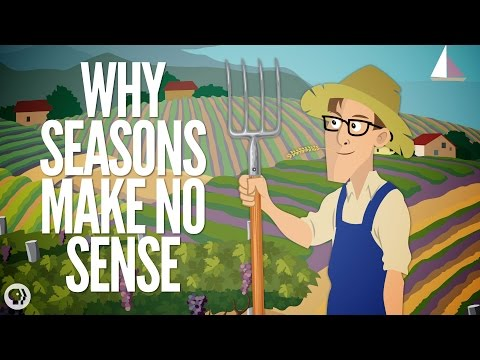

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("s0oX9YJ5XLo", 640, 480)

### Seasons definitions in Japan

In Japan, seasons are usually defined as to match with the months of the year: summer is June, July and August; winter is December, February and March. This leads to a difference of 21-22 days from the solstice-based western definition. However, more often than not, September still feels pretty much like summer and snow in March is not rare even in the not so cold regions of the country.

### Testing the definitions with data

So, I decided to [download data](http://www.data.jma.go.jp/obd/stats/etrn/index.php) from the Japanese Meteorological Agency (気象庁) and try applying the the meteorological definition of seasons shown in the video. The data used here is from Tokyo, so data from different measurement points from across the country will likely yield slightly different results.

Below I present a simple analysis in Python 3 code.

------------------------------------


In [3]:
from itertools import chain
from zipfile import ZipFile
from io import BytesIO
import re
import requests
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
%matplotlib notebook

## Downloading/parsing
I have done some `sed`-based pre-processing on the not-so-machine friendly csv-like format in which the JMA provides the data. I have made it a available in a Dropbox for those who want to take a look at the raw data.

Below I parse the data and generate a pandas `DataFrame` for further analysis.

In [7]:
def parse_data(fname):
    """Reads/cleans the raw data and returns a `DataFrame`"""
    df = pd.read_csv(zipfile.open(fname))
    remove_cols = set(chain(*[re.findall('.*\.\d$', col) for col in list(df.columns)]))
    cols = set(df.columns) - remove_cols
    df = df[sorted(cols)]
    df = df.set_index('年月日', drop=True)
    df.index = pd.to_datetime(df.index)
    df.columns = ['precipitation_10min', 'avg_temp', 'sunshine',
                  'avg_wind', 'min_temp', 'max_temp', 'precipitation_total']
    df = df[sorted(df.columns)]
    return df

# Downloading data files
url = 'https://dl.dropboxusercontent.com/u/18085964/tenki_data.zip'
zipfile = ZipFile(BytesIO(requests.get(url).content))

# Doing the acutal data cleaning
files = ['data_'+str(i).zfill(2)+'.csv' for i in range(17)]
df = pd.concat([parse_data(fname) for fname in zipfile.namelist()], axis=0)
df = df.sort_index()
df.index.name = 'date'

# Ad-hoc filling the only missing value in all temperature data
df.ix['1994-07-18', 'min_temp'] = 25.0  

After some processing her is how the data looks like:

In [5]:
df.tail(10)

,avg_temp,avg_wind,max_temp,min_temp,precipitation_10min,precipitation_total,sunshine
date,,,,,,,
2015-12-22,11.0,8.9,15.9,7.3,0.0,0.0,3.4
2015-12-23,6.8,0.0,8.6,5.5,1.0,4.0,2.4
2015-12-24,10.3,3.9,15.4,5.5,0.5,5.0,2.3
2015-12-25,10.9,6.5,15.0,7.6,0.0,0.0,3.2
2015-12-26,8.5,7.6,12.5,5.8,0.0,0.0,2.3
2015-12-27,7.3,3.7,10.5,3.7,0.0,0.0,3.3
2015-12-28,6.0,7.9,10.6,2.6,0.0,0.0,2.4
2015-12-29,6.3,8.8,11.5,1.9,0.0,0.0,2.5
2015-12-30,7.2,7.6,11.0,4.0,0.0,0.0,2.3


## Analysis

Here I plot the 91-day ($\approx 365.25/4$) moving averages of the temperatures. From the meteorological definition of the seasons presented in the video, the days in which the moving averages are the highest/lowest in the year correspond to the end of summer/winter, respectively.

<IPython.core.display.Javascript object>


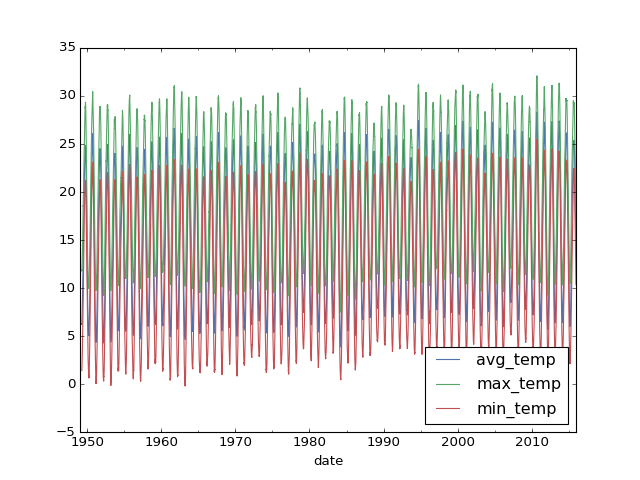

In [6]:
roll = df[['avg_temp', 'max_temp', 'min_temp']].rolling(91).mean()
_ = roll.plot()

A zoomed-in version:

<IPython.core.display.Javascript object>


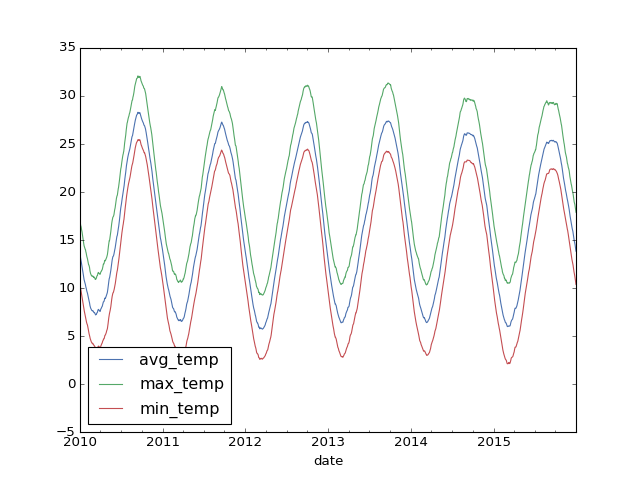

In [153]:
_ = roll.plot(xlim=['2010-01-01', '2015-12-31'])

Here, we will apply the definition of summer/winter with two types of temperature data:

    1. maximum `max_temp` / minimum `min_temp`
    1. maximum `avg_temp` / minimum `avg_temp`
    
Below we construct a `DataFrame` containing the number of days since the beginning of the year in which summer/winter ends.
Note that we are glossing over leap years and other small details.

In [108]:
summer_end = []
winter_end = []
summer_end_avg = []
winter_end_avg = []

for _, data in roll.groupby(pd.TimeGrouper('A')):
    winter_end.append(data['min_temp'].argmin())
    summer_end.append(data['max_temp'].argmax())
    winter_end_avg.append(data['avg_temp'].argmin())
    summer_end_avg.append(data['avg_temp'].argmax())
    

def day_number(date):
    """Returns number of days from the beginning of the year"""
    year_begin = pd.Timestamp(str(date.year - 1)) + pd.offsets.YearBegin()
    td = date - year_begin
    return td.days

ndays = pd.DataFrame({
         'summer_end':[day_number(date) for date in summer_end],
         'winter_end':[day_number(date) for date in winter_end],
         'summer_end_avg':[day_number(date) for date in summer_end_avg],
         'winter_end_avg':[day_number(date) for date in winter_end_avg]
        }, index=range(1949, 2016))

ndays = ndays.iloc[1:] # Removing 1949

## Results
Below we show some basic stats on the number of days in the year until the end of summer/winter using both of types of temperature data mentioned above.

In [147]:
end_str = '\n'+'-'*50+'\n'
cols = ['mean', 'std']
print(ndays.describe().ix[cols], end=end_str)             # 1950-2015
print(ndays.iloc[:-33].describe().ix[cols], end=end_str)  # 1950-1982
print(ndays.iloc[-33:].describe().ix[cols], end=end_str)  # 1983-2015
ndays.tail(10)

      summer_end  summer_end_avg  winter_end  winter_end_avg
mean  261.666667      262.303030   69.984848       70.181818
std     8.799184        6.616924    7.616768        7.601435
--------------------------------------------------
      summer_end  summer_end_avg  winter_end  winter_end_avg
mean  260.939394      261.727273   68.575758       69.636364
std     7.988036        6.534871    8.828329        7.924717
--------------------------------------------------
      summer_end  summer_end_avg  winter_end  winter_end_avg
mean  262.393939      262.878788   71.393939       70.727273
std     9.610994        6.748878    5.984038        7.345376
--------------------------------------------------


,summer_end,summer_end_avg,winter_end,winter_end_avg
2006,254,254,63,62
2007,267,267,80,77
2008,269,269,72,69
2009,259,259,73,71
2010,256,256,72,69
2011,261,261,83,83
2012,274,275,64,75
2013,264,264,65,58
2014,237,252,70,69
2015,235,255,63,61


## Discussion
It doesn't seem there is any significant change in the end of seasons in the past 66 years as can be seen from the above data and the plot below.

However, one interesting thing to note is that if we define the mid-seasons (spring, autumn) as the period between summer/winter the results above imply that in Tokyo spring is slightly longer than autumn.

<IPython.core.display.Javascript object>


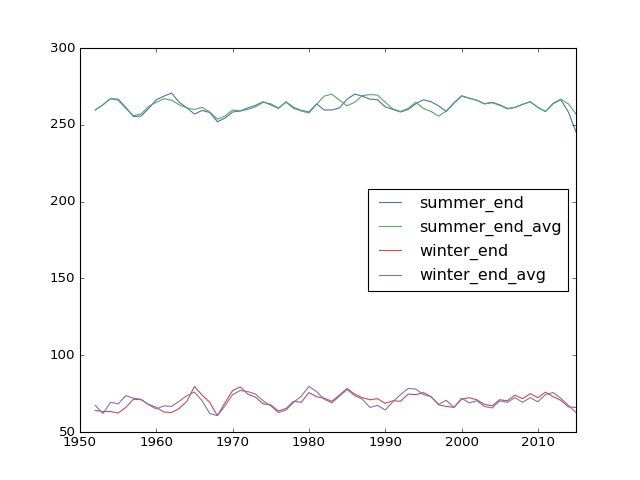

In [149]:
_ = ndays.rolling(3).mean().plot()

## Conclusion
From the results above, we can conclude that, in Tokyo, **on average**, the end of summer is **September 20th** and the end of winter is **March 12th**, give or take a day depending on how you interpret the results above.

Next time you are discussing with Japanese friends about why the hell so many pools/beaches close on September 1st, few free to use this notebook as ground for argument 😬

In [8]:
print((pd.Timestamp('2015') + pd.Timedelta(262, 'd')).date())
print((pd.Timestamp('2015') + pd.Timedelta(70, 'd')).date())

2015-09-20
2015-03-12
